In [2]:
import numpy as np
import matplotlib.pyplot as plt
from simulate import *
import pickle



import matplotlib 
matplotlib.rc('xtick', labelsize=27) 
matplotlib.rc('ytick', labelsize=27)

In [20]:
def sim_data(inc_earth, period_jup, roman_err, roman_duration, gaia_obs):

	'''
	inc_earth = Earth inclination in degrees (Jupiter assumed 1.31 degrees greater than this value)
	period_jup = Jupiter period in days 
	roman_err = roman error in arcseconds, if None assumed no Roman observations
	'''




	##################
	##################
	##################
	##################
	#begin simulate data
	##################
	##################
	##################
	##################
	##################

	T_subtract = 2454000
	# orbital parameters from https://www.princeton.edu/~willman/planetary_systems/Sol/
	# BJD determined by converting values above using https://ssd.jpl.nasa.gov/tc.cgi#top

	P_earth = 300
	e_earth = 0.0167
	Tper_earth= 100
	omega_earth = np.radians(102.9)
	Omega_earth = np.radians(0.0)
	inclination_earth = np.radians(inc_earth)
	m_earth = 1*3.00273e-6 #units m_sun



	P_jup = period_jup	
	e_jup = 0.0484
	Tper_jup = 500
	omega_jup = np.radians(274.3) - 2*np.pi
	Omega_jup = np.radians(100.4)
	inclination_jup = np.radians(1.31) + inclination_earth
	m_jup = 317.83*3.00273e-6 #units m_sun


	m_sun = 333030 #earth masses


	#add gaia observing times
	times_observed_astrometry_gaia = []
	t_0 = int(Tper_earth)
	for ii in range(t_0, t_0+3600):
		if ii % (3600/gaia_obs) == 0:
			times_observed_astrometry_gaia.append(ii)

	
			
	#add THE observing times
	times_observed_rv = []
	t_0 = int(Tper_earth)
	add_data = True
	for ii in range(t_0, t_0+3600):
		
		if ii % 180 == 0:
			if add_data:
				add_data = False
			else:
				add_data = True
		   
		if add_data:
			times_observed_rv.append(ii)
			

	orbit_params_earth = [P_earth, e_earth, Tper_earth, omega_earth, Omega_earth, inclination_earth, m_earth]
	orbit_params_jup = [P_jup, e_jup, Tper_jup, omega_jup, Omega_jup, inclination_jup, m_jup]

	n_planets = 2
	orbit_params = [orbit_params_earth, orbit_params_jup]


	sigma_rv = 0.3

	sigma_ra_gaia = 6e-5
	sigma_dec_gaia = 6e-5
	parallax = 0.1 #as



	times, rv_results, ra_results, dec_results = simulate_data(
		n_planets, 
		sigma_rv, 
		sigma_ra_gaia,
		sigma_dec_gaia,
		parallax,
		orbit_params,
		times_observed_rv = times_observed_rv,
		times_observed_astrometry = times_observed_astrometry_gaia
		)


	[[times_rv, times_observed_rv, times_astrometry, times_observed_astrometry],
	[rv_orbit, rv_orbit_sum, rv_sim, rv_sim_sum],
	[ra_orbit, ra_orbit_sum, ra_sim, ra_sim_sum],
	[dec_orbit, dec_orbit_sum, dec_sim, dec_sim_sum]]  = times, rv_results, ra_results, dec_results

	ra_gaia_err = np.full(np.shape(ra_sim_sum), sigma_ra_gaia)
	dec_gaia_err = np.full(np.shape(dec_sim_sum), sigma_dec_gaia)


	#add roman observing times if roman_err not None
	if roman_err is not None:
		t_1 =  times_observed_astrometry_gaia[-1]+1800
		times_observed_astrometry_roman = []
		for ii in range(t_1, t_1+(roman_duration*365)):
			if ii % 90 == 0:
				times_observed_astrometry_roman.append(ii)	


		sigma_ra_roman = roman_err
		sigma_dec_roman = roman_err



		times, rv_results, ra_results, dec_results = simulate_data(
			n_planets, 
			sigma_rv, 
			sigma_ra_roman,
			sigma_dec_roman,
			parallax,
			orbit_params,
			times_observed_rv = times_observed_rv,
			times_observed_astrometry = times_observed_astrometry_roman
			)

		times_astrometry = np.append(times_astrometry, times[2], axis=0)

		times_observed_astrometry = np.append(times_observed_astrometry, times[3], axis=0)

		ra_orbit = np.append(ra_orbit, ra_results[0], axis=0)
		ra_orbit_sum = np.append(ra_orbit_sum, ra_results[1], axis=0)
		ra_sim = np.append(ra_sim, ra_results[2], axis=0)
		ra_sim_sum = np.append(ra_sim_sum, ra_results[3], axis=0)

		dec_orbit = np.append(dec_orbit, dec_results[0], axis=0)
		dec_orbit_sum = np.append(dec_orbit_sum, dec_results[1], axis=0)
		dec_sim = np.append(dec_sim, dec_results[2], axis=0)
		dec_sim_sum = np.append(dec_sim_sum, dec_results[3], axis=0)

		ra_roman_err = np.full(np.shape(ra_results[3]), sigma_ra_roman)
		dec_roman_err = np.full(np.shape(dec_results[3]), sigma_dec_roman)


	
	##################
	##################
	##################
	##################
	#end simulate data
	##################
	##################
	##################
	##################
	##################



	##################
	##################
	##################
	##################
	#begin model data
	##################
	##################
	##################
	##################
	##################

	################
	################
	#rename variables in more consistent way for modeling
	x_rv = np.array(times_observed_rv)
	y_rv = rv_sim_sum
	y_rv_err = np.full(np.shape(y_rv), sigma_rv)

	x_astrometry = np.array(times_observed_astrometry)
	ra_data = ra_sim_sum
	dec_data = dec_sim_sum


	if roman_err is not None:
		ra_err = np.concatenate((ra_gaia_err, ra_roman_err))
		dec_err = np.concatenate((dec_gaia_err, dec_roman_err))

	else:
		ra_err = ra_gaia_err
		dec_err = dec_gaia_err



	# make a fine grid that spans the observation window for plotting purposes
	t_astrometry = np.linspace(x_astrometry.min() - 5, x_astrometry.max() + 5, 1000)
	t_rv = np.linspace(x_rv.min() - 5, x_rv.max() + 5, 1000)

	# for predicted orbits
	t_fine = np.linspace(x_astrometry.min() - 500, x_astrometry.max() + 500, num=1000)
    
	return x_rv, t_rv, y_rv, y_rv_err, x_astrometry, t_astrometry, \
    t_fine, ra_data, dec_data, ra_err, dec_err, \
    times_rv, times_astrometry, rv_orbit, ra_orbit, dec_orbit



In [93]:




def make_plots(roman_vars, file):
#for ii in range(0, len(roman_vars)):
    x_rv, t_rv, y_rv, y_rv_err, x_astrometry, t_astrometry, t_fine,\
    ra_data, dec_data, ra_err, dec_err, times_rv, times_astrometry, rv_orbit, ra_orbit, dec_orbit = sim_data(
        inc_earth, period_jup, roman_vars[0], roman_vars[1], gaia_obs)
    
    
    # add NaN for plotting purpose on true model
    times_astrometry = np.insert(times_astrometry, 10000, float('NaN'))
    ra_orbit = np.insert(ra_orbit, 10000, float('NaN'), axis=0)
    dec_orbit = np.insert(dec_orbit, 10000, float('NaN'),axis=0)
            
    
    tot_dec_err = roman_vars
    


    with open('./traces/Oct27/'+file, 'rb') as buff:
        data = pickle.load(buff)  

    model, trace = data['model'], data['trace']
    
    
    
    
    ################
    #plot astrometry
    
    figAs, ax = plt.subplots(2, 2, figsize = [18,9], sharey=True)
    for n, letter in enumerate(["Earth", "Jupiter"]):
        ax0, ax1 = ax[n][0], ax[n][1]

        # Get the posterior median orbital parameters
        p = np.median(trace.posterior["P"].values[:, :, n])
        t0 = np.median(trace.posterior["tperi"].values[:, :, n])

        # Compute the median of posterior estimate the other planet. Then we can remove
        # this from the data to plot just the planet we care about.
        other = np.median(
            trace.posterior["dec"].values[:, :, :, (n + 1) % 2], axis=(0, 1)
        )






        # plot the DEC data
        ax0.errorbar(x_astrometry, dec_data - other, yerr=dec_err, fmt=".", 
                     color = "#00257c", label = "data", alpha = 0.7)

        # plot the MCMC DEC model
        pred = np.percentile(
            trace.posterior["dec_fine"].values[:, :, :, n],
            [16, 50, 84],
            axis=(0, 1),
        )


        ax0.plot(t_fine, pred[1], color="k", label="MCMC model")
        art = ax0.fill_between(
            t_fine, pred[0], pred[2], color="k", alpha=0.3
        )
        art.set_edgecolor("none")


        # plot the true DEC model
        ax0.plot(times_astrometry, dec_orbit.T[n], color = 'r', label = "true model")








        # Get the posterior median orbital parameters
        p = np.median(trace.posterior["P"].values[:, :, n])
        t0 = np.median(trace.posterior["tperi"].values[:, :, n])

        # Compute the median of posterior estimate the other planet. Then we can remove
        # this from the data to plot just the planet we care about.
        other = np.median(
            trace.posterior["ra"].values[:, :, :, (n + 1) % 2], axis=(0, 1)
        )
        





        # Plot the RA data
        ax1.errorbar(x_astrometry, ra_data - other, yerr=ra_err, fmt=".", 
                     color = "#00257c", label = "data", alpha = 0.7)


        pred = np.percentile(
            trace.posterior["ra_fine"].values[:, :, :, n],
            [16, 50, 84],
            axis=(0, 1), 
        )



        # plot the MCMC RA model
        ax1.plot(t_fine, pred[1], color="k", label="MCMC model")
        art = ax1.fill_between(
            t_fine, pred[0], pred[2], color="k", alpha=0.3
        )
        art.set_edgecolor("none")
        
        # plot the true RA model
        ax1.plot(times_astrometry, ra_orbit.T[n], color = 'r', label = "true model")








        ax0.legend(fontsize=18, loc=3)
        ax0.set_xlabel("time [days]", fontsize=18)
        ax0.set_ylabel(r"$\Delta \delta$ ['']", fontsize = 18)
        ax0.set_title("{0} Dec".format(letter), fontsize=27)
        
        ax1.legend(fontsize=18, loc=3)
        ax1.set_xlabel("time [days]", fontsize=18)
        ax1.set_ylabel(r"$\Delta \alpha \cos \delta$ ['']", fontsize = 18)
        ax1.set_title("{0} RA".format(letter), fontsize=27)

        
        
        
        
        #ax[1].set_ylabel(r"[O-C]", fontsize = 36)
        #ax[3].set_ylabel(r"[O-C]", fontsize = 36)
        figAs.tight_layout()
        figAs.suptitle('Astrometry: ' + file[:-4], fontsize=36)
        #fig.savefig('./comparison_figures2/astrometry_'+file+'.pdf')
        
        
        
        
        
            
        
        
    ######
    #make rv plots
    matplotlib.rc('xtick', labelsize=18) 
    matplotlib.rc('ytick', labelsize=18)
    change_to_NaN = False #creates gap in plot
    figRV, axs = plt.subplots(2, 1, figsize = [13, 9])
    for n, letter in enumerate(["Earth", "Jupiter"]):
        ax = axs[n]

        # Get the posterior median orbital parameters
        p = np.median(trace.posterior["P"].values[:, :, n])
        t0 = np.median(trace.posterior["tperi"].values[:, :, n])

        # Compute the median of posterior estimate the other planet. Then we can remove
        # this from the data to plot just the planet we care about.
        other = np.median(
            trace.posterior["vrad"].values[:, :, :, (n + 1) % 2], axis=(0, 1)
        )







        # Plot the data
        ax.errorbar(x_rv, y_rv - other, yerr=y_rv_err, fmt=".", 
                     color = "#00257c", label = "data", alpha = 0.7)


        pred = np.percentile(
            trace.posterior["vrad_pred"].values[:, :, :, n],
            [16, 50, 84],
            axis=(0, 1),
        )

        #t_plot = t_fold[inds].copy()
        #for ii in range(1, len(t_plot)):
        #    if t_plot[ii] - t_plot[ii-1] > 180:
        #        change_to_NaN = True
        #        NaN_index = ii

        #if change_to_NaN:
        #    t_plot[NaN_index] = float('NaN')
        #    t_plot[NaN_index-1] = float('NaN')
        #    change_to_NaN = False

        
        # plot the MCMC model
        ax.plot(t_rv, pred[1], color="k", label="MCMC model")
        art = ax.fill_between(
            t_rv, pred[0], pred[2], color="k", alpha=0.3
        )
        art.set_edgecolor("none")
        
        # plot the true RA model
        ax.plot(times_rv, rv_orbit.T[n], color = 'r', label = "true model")








        ax.legend(fontsize=18, loc=1)
        ax.set_xlabel("phase [days]", fontsize=18)
        ax.set_ylabel("radial velocity [m/s]", fontsize=18)
        ax.set_title("{0}".format(letter), fontsize=27)


        figRV.tight_layout()
        figRV.subplots_adjust(hspace=0.5)
        #fig.savefig('./comparison_figures2/rv_'+ file+'.pdf')
        figRV.suptitle('RV: ' + file[:-4], fontsize=36)
        
        
    return figAs, figRV



[6.e-05 6.e-05 6.e-05 6.e-05 6.e-05 6.e-05 6.e-05 6.e-05 6.e-05 6.e-05
 6.e-05 6.e-05 6.e-05 6.e-05 6.e-05 6.e-05 6.e-05 6.e-05 6.e-05 6.e-05
 6.e-05 6.e-05 6.e-05 6.e-05 6.e-05 6.e-05 6.e-05 6.e-05 6.e-05 6.e-05
 6.e-05 6.e-05 6.e-05 6.e-05 6.e-05 6.e-05 6.e-05 6.e-05 6.e-05 6.e-05
 6.e-05 6.e-05 6.e-05 6.e-05 6.e-05 6.e-05 6.e-05 6.e-05 6.e-05 6.e-05
 6.e-05 6.e-05 6.e-05 6.e-05 6.e-05 6.e-05 6.e-05 6.e-05 6.e-05 6.e-05
 6.e-05 6.e-05 6.e-05 6.e-05 6.e-05 6.e-05 6.e-05 6.e-05 6.e-05 6.e-05
 6.e-05 6.e-05 6.e-05 6.e-05 6.e-05 6.e-05 6.e-05 6.e-05 6.e-05 6.e-05
 6.e-05 6.e-05 6.e-05 6.e-05 6.e-05 6.e-05 6.e-05 6.e-05 6.e-05 6.e-05
 6.e-05 6.e-05 6.e-05 6.e-05 6.e-05 6.e-05 6.e-05 6.e-05 6.e-05 6.e-05
 6.e-05 6.e-05 6.e-05 6.e-05 6.e-05 6.e-05 6.e-05 6.e-05 6.e-05 6.e-05
 6.e-05 6.e-05 6.e-05 6.e-05 6.e-05 6.e-05 6.e-05 6.e-05 6.e-05 6.e-05
 6.e-05 6.e-05 6.e-05 6.e-05 6.e-05 6.e-05 6.e-05 6.e-05 6.e-05 6.e-05
 6.e-05 6.e-05 6.e-05 6.e-05 6.e-05 6.e-05 6.e-05 6.e-05 6.e-05 6.e-05
 6.e-0

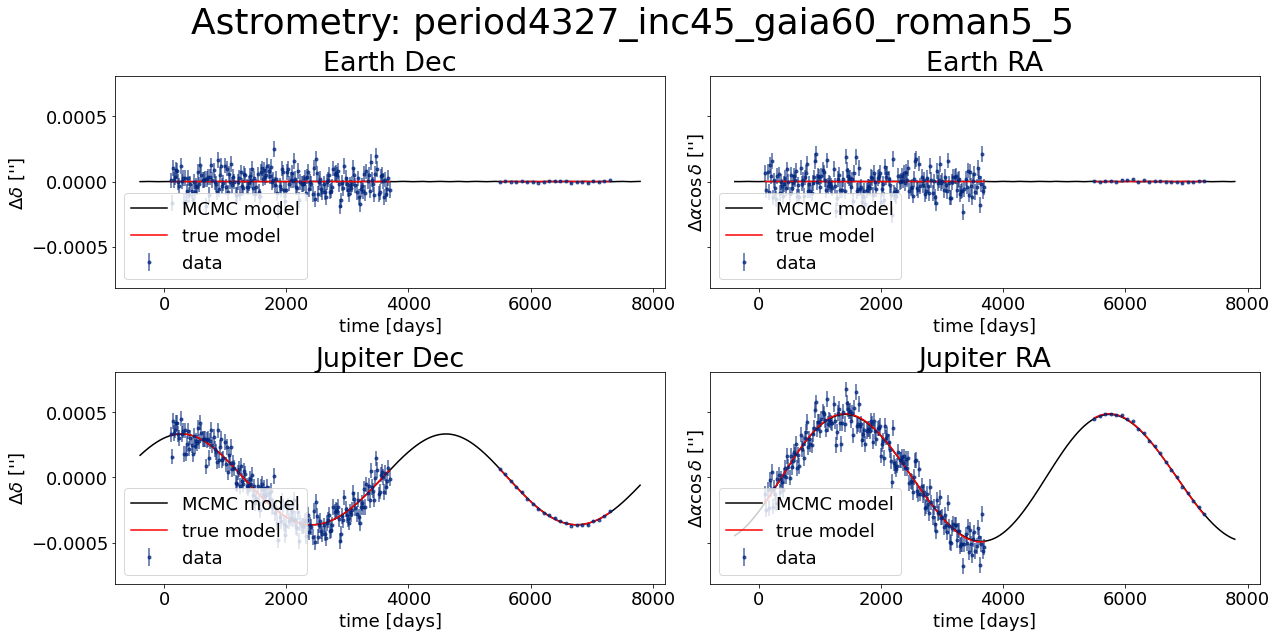

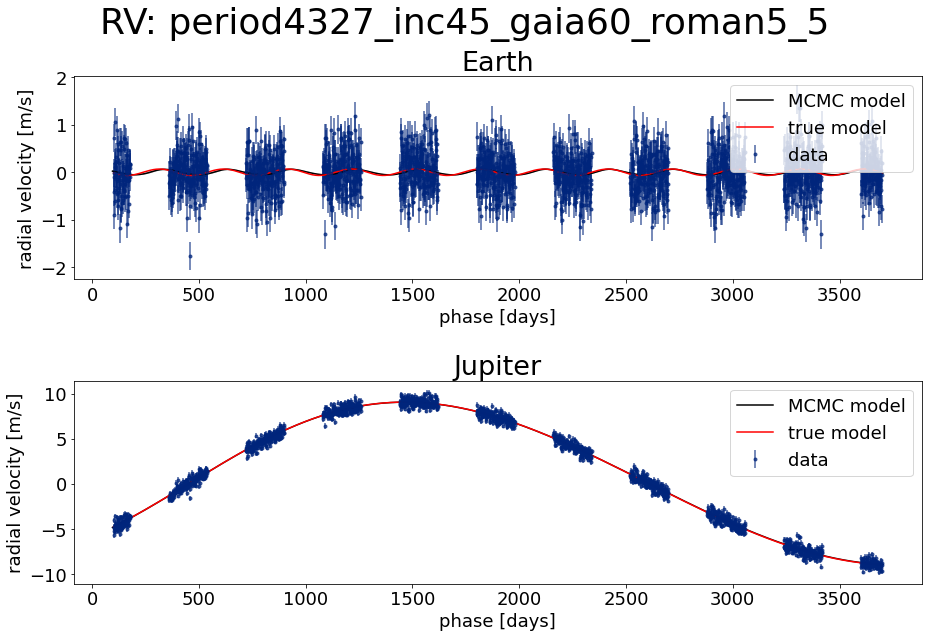

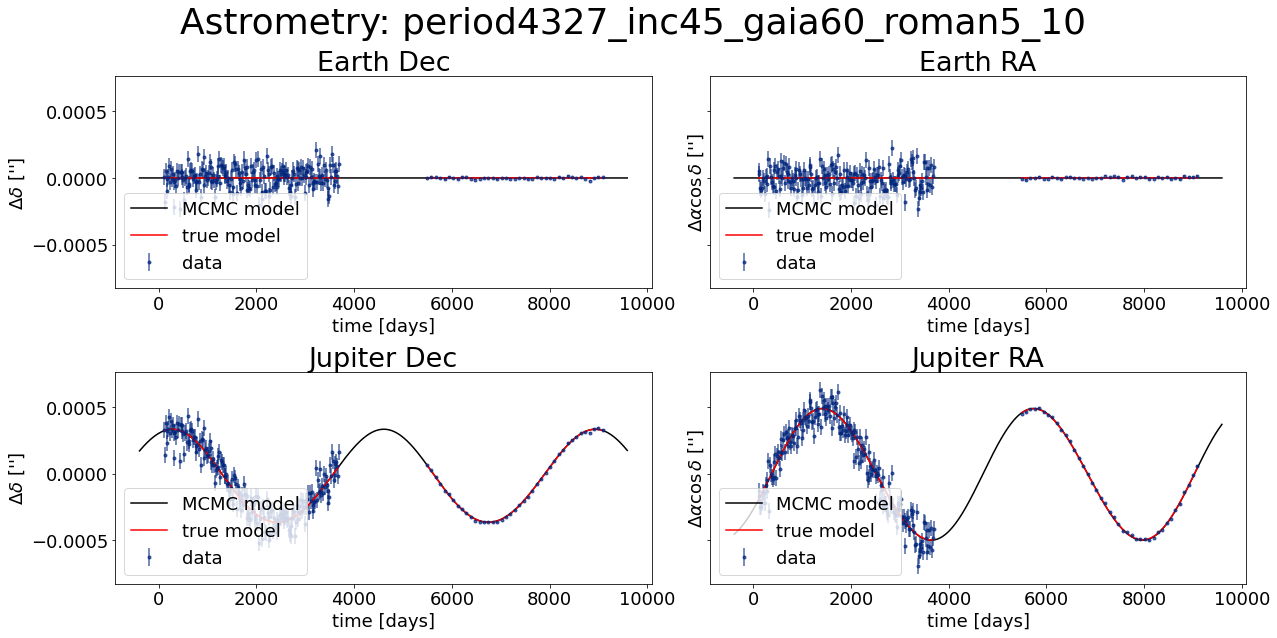

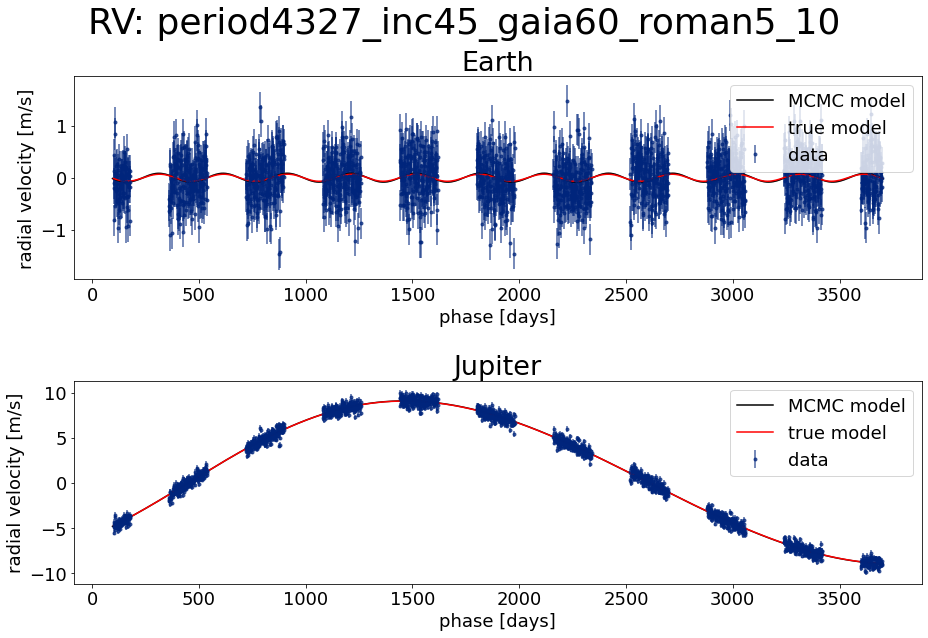

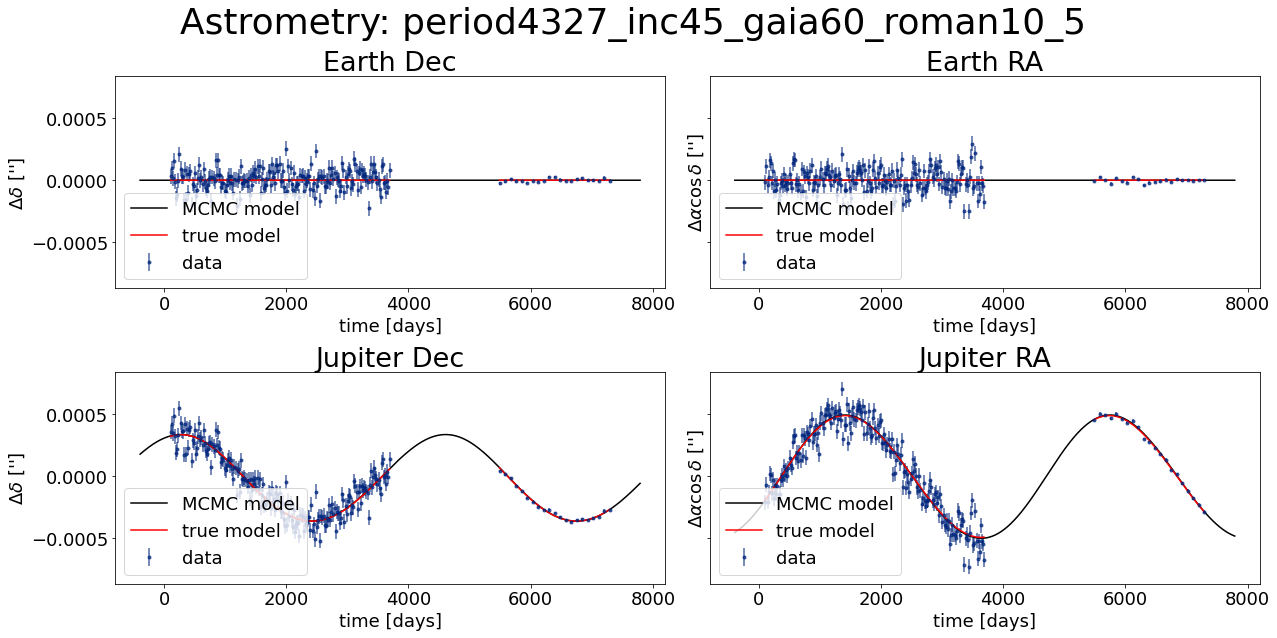

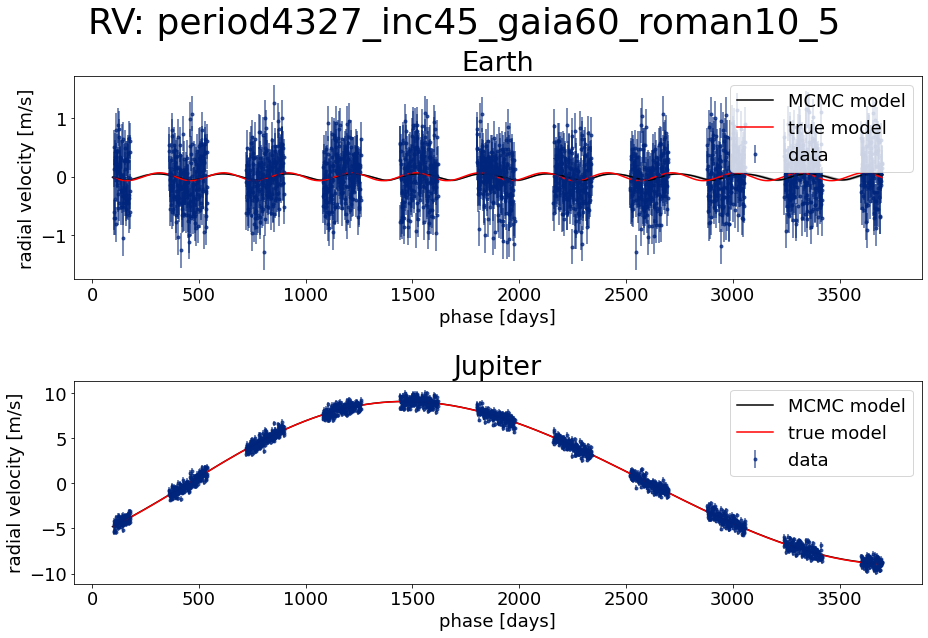

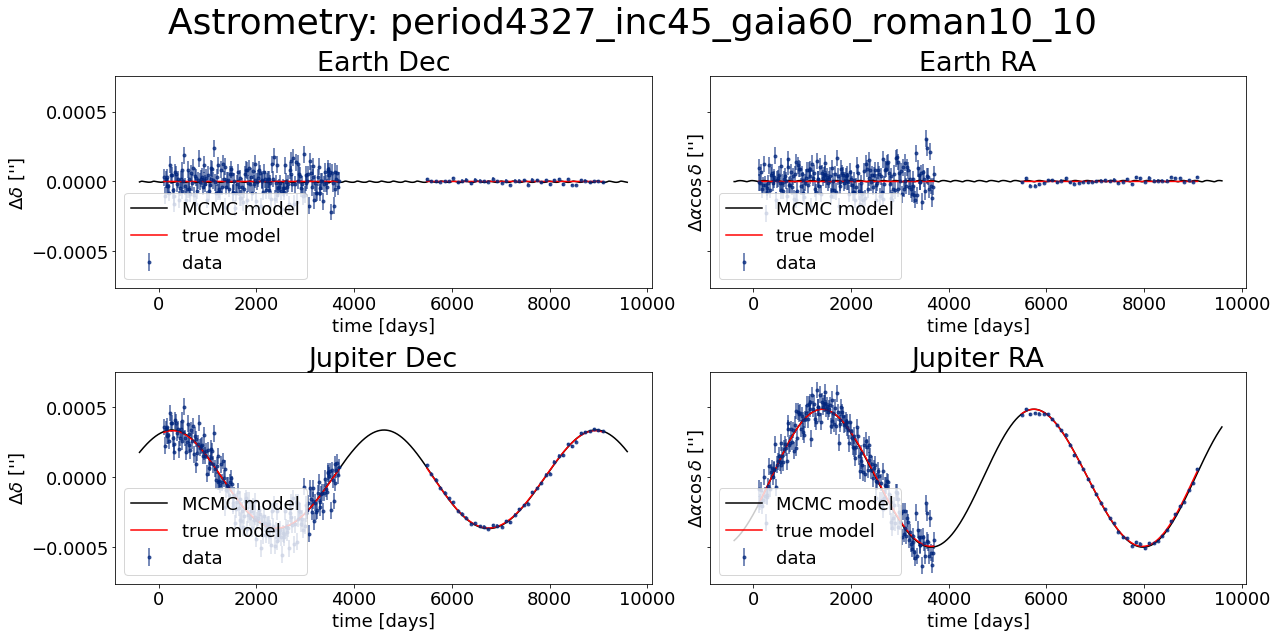

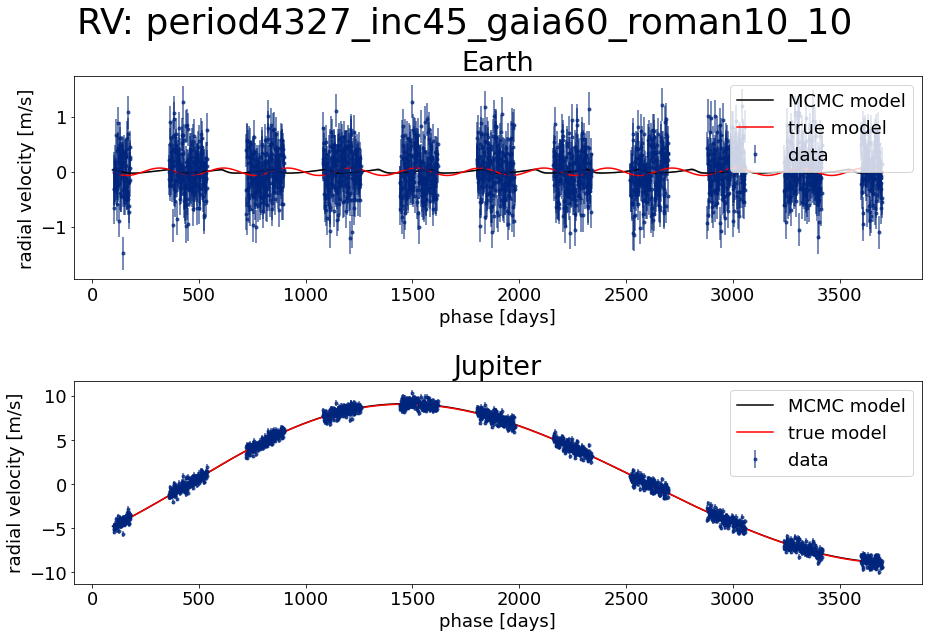

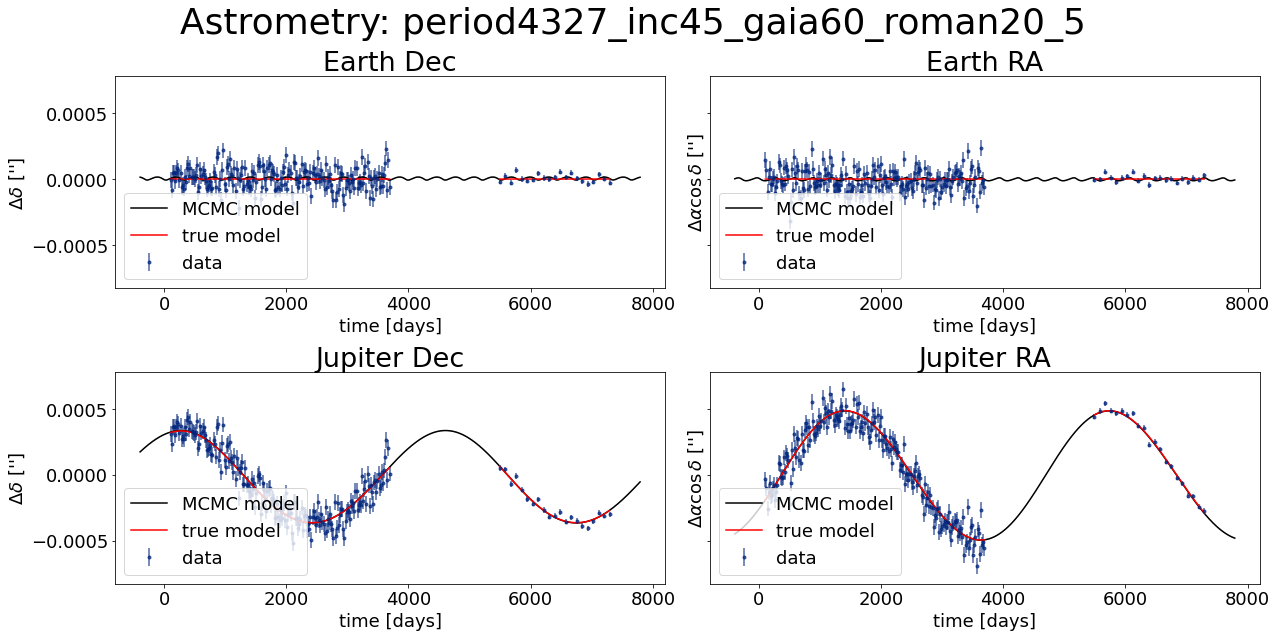

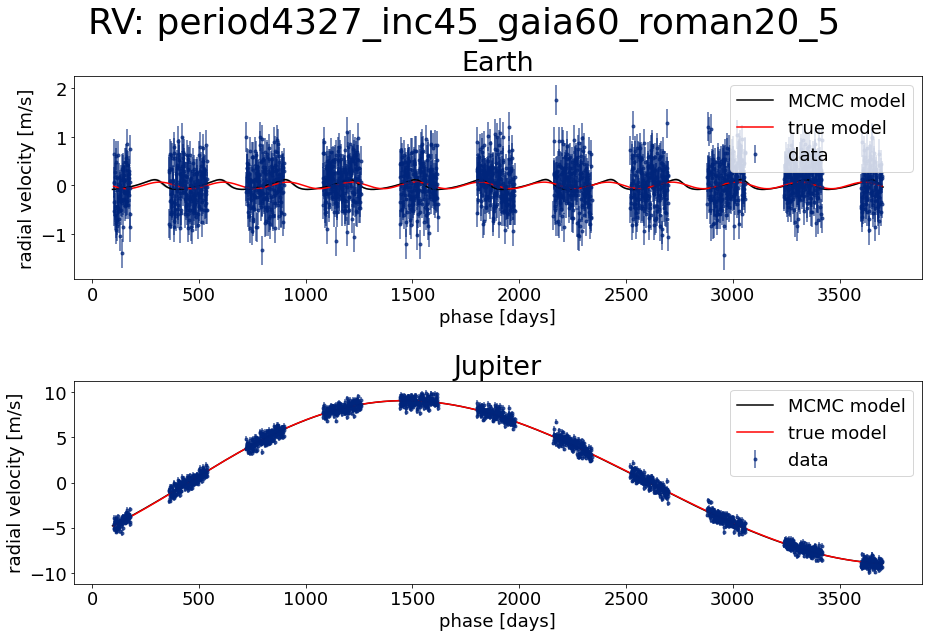

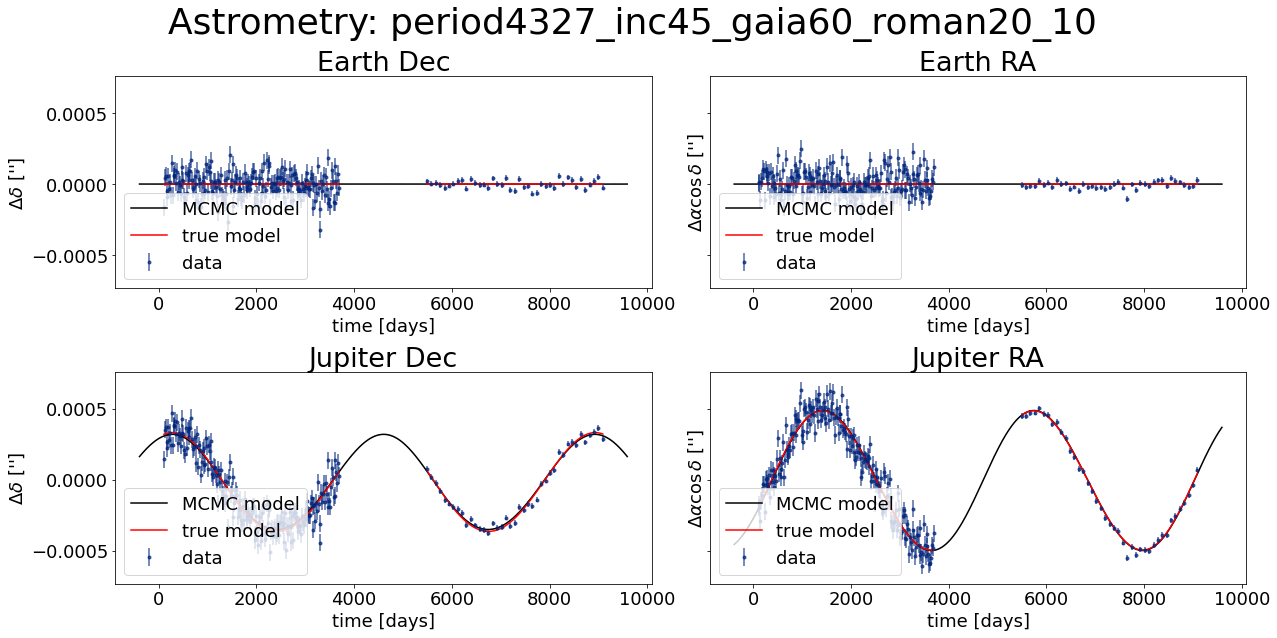

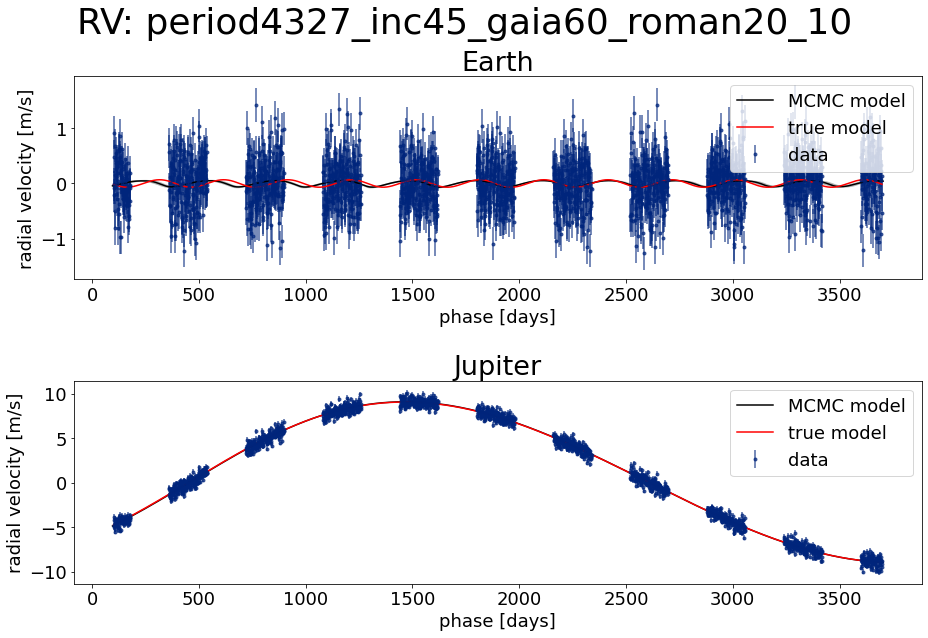

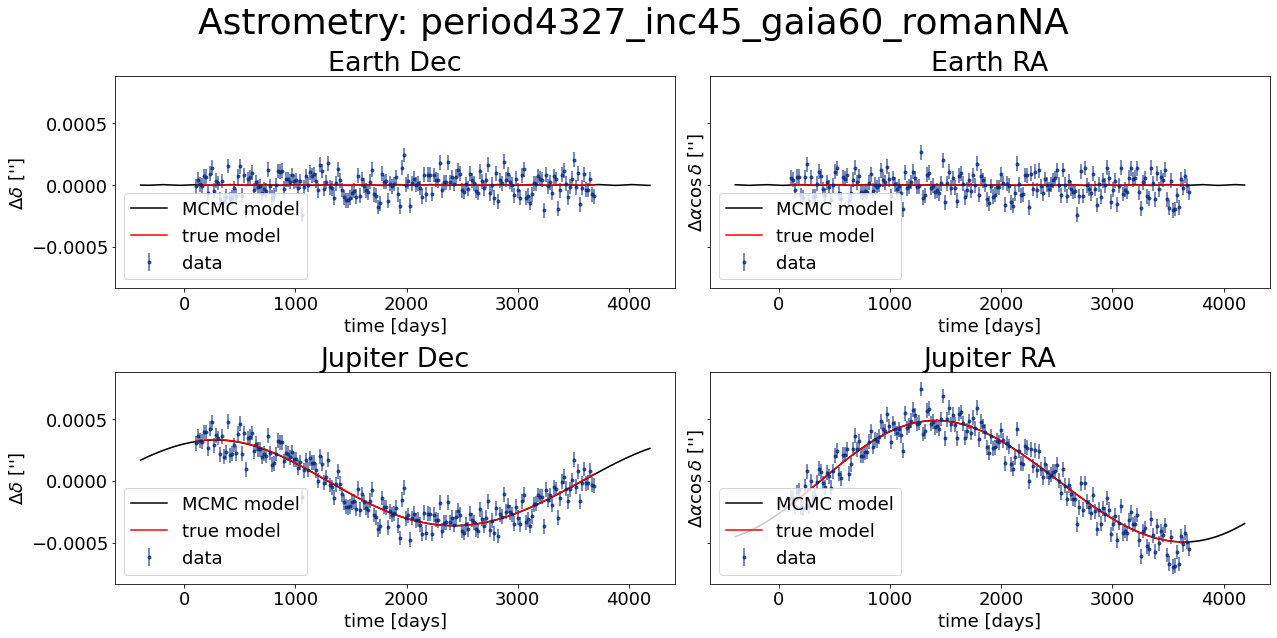

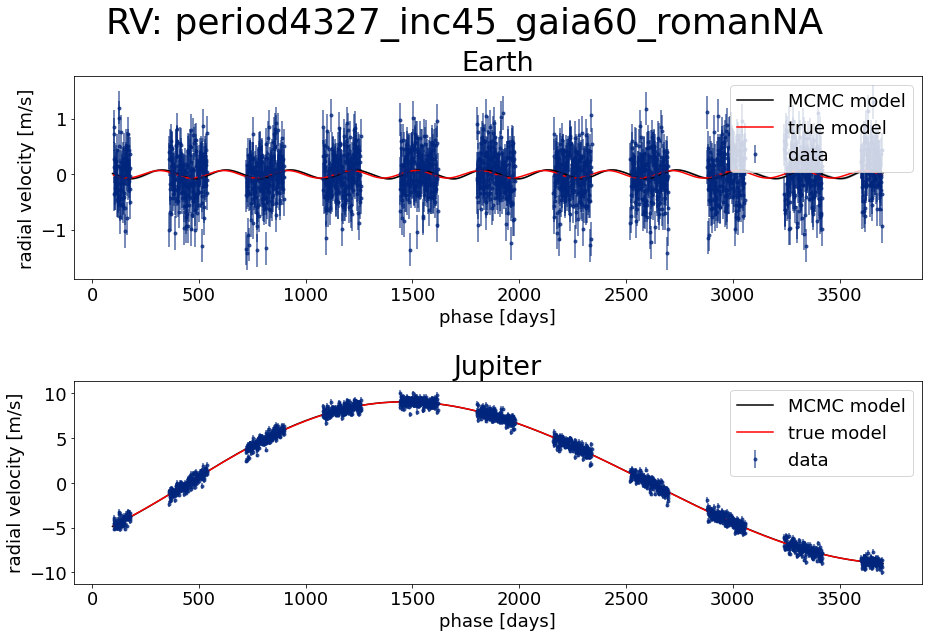

In [94]:
files = [
'period4327_inc45_gaia60_roman5_5.pkl',
'period4327_inc45_gaia60_roman5_10.pkl',
'period4327_inc45_gaia60_roman10_5.pkl',
'period4327_inc45_gaia60_roman10_10.pkl',
'period4327_inc45_gaia60_roman20_5.pkl',
'period4327_inc45_gaia60_roman20_10.pkl',
'period4327_inc45_gaia60_romanNA.pkl'
]

period_jup = 4327
inc_earth = 45.0
roman_vars =[
    [5e-6,5],
    [5e-6,10],
    [10e-6,5],
    [10e-6,10],
    [20e-6,5],
    [20e-6,10],
    [None,None]
]
gaia_obs = 200


P_earth = 300
e_earth = 0.0167
Tper_earth= 100
omega_earth = np.radians(102.9)
Omega_earth = np.radians(0.0)
inclination_earth = np.radians(inc_earth)
m_earth = 1*3.00273e-6 #units m_sun



P_jup = period_jup
e_jup = 0.0484
Tper_jup = 500
omega_jup = np.radians(274.3) - 2*np.pi
Omega_jup = np.radians(100.4)
inclination_jup = np.radians(1.31) + inclination_earth
m_jup = 317.83*3.00273e-6 #units m_sun


m_sun = 333030 #earth masses


from matplotlib.backends.backend_pdf import PdfPages

for ii in range(0, len(roman_vars)):
    figs = make_plots(roman_vars[ii], files[ii])
    pp = PdfPages('comparison_figures2/diagnostic'+str(ii+1)+'.pdf')
    pp.savefig(figs[1])
    pp.savefig(figs[0])
    pp.close()
